In [111]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

# load data

In [112]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})
df = df[df["Community"] != "-1"]

for col in df.iloc[:,2:].columns:
    df = df[df[col] != -1]

df.head()

,id,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
7,7,Comm.FOSSASIA,5,5,5,5,2,1,2
9,9,Comm.ROS,5,5,5,5,1,1,3
10,10,Comm.ROS,5,4,4,4,1,1,4


In [113]:
df.iloc[:,2:].describe()

,V27,V28,V29,V30,V31,V32,V33
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,4.115152,4.181818,3.987879,4.381818,2.072727,1.769697,2.466667
std,0.965288,0.983230,1.059152,0.927051,1.009489,0.947553,0.984845
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,2.000000
50%,4.000000,4.000000,4.000000,5.000000,2.000000,2.000000,2.000000
75%,5.000000,5.000000,5.000000,5.000000,3.000000,2.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


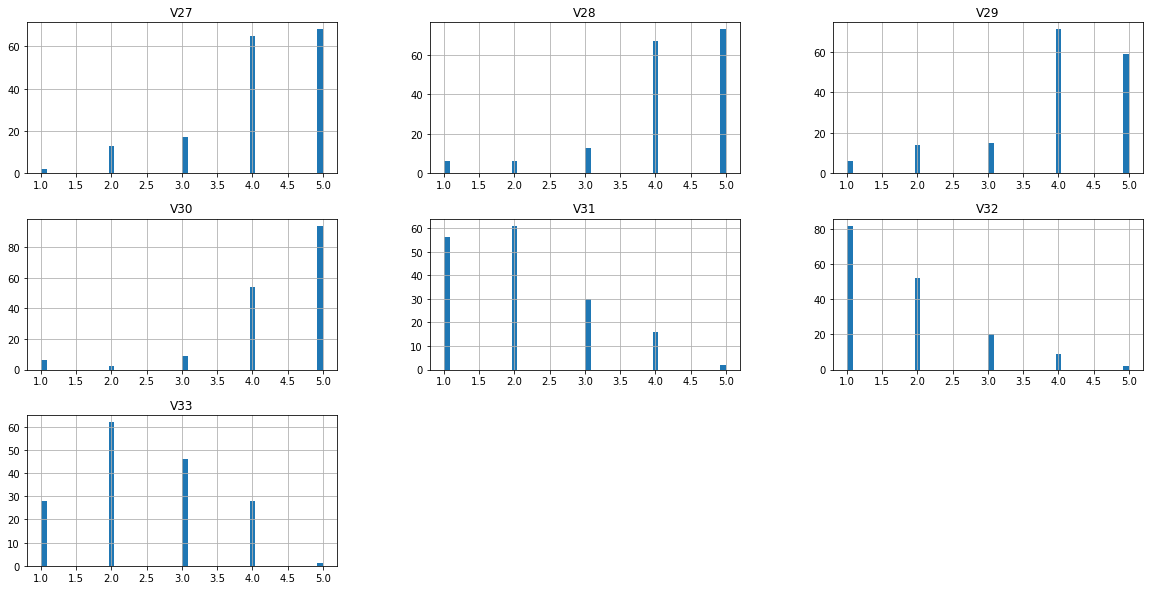

In [114]:
df.hist(column=df.columns[1:], bins=50, figsize=(20,10))
plt.show()

In [115]:
# V27 = df[df.Community == 'Comm.FOSSASIA'].V27.to_numpy()

def removeNoAnswer(lst):
    return [i for i in lst if i!=-1]
#    return lst[np.where(lst != -1)]
def standardize(data, m, sd):
    return (data-m)/sd

data = []
communities = df.Community.unique();
for com in communities:
    columns  = []
    for question in df.iloc[:,2:].columns:
        columns.append(removeNoAnswer(df[df.Community == com][question].to_numpy()))
    positive = [[int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    z = [standardize(columns[i], μ[i], σ[i]) for i in range(len(columns))]
    
    N_positive = [len(v) for v in positive]
    μ_positive = [np.mean(v) for v in positive]
    σ_positive = [np.std(v) for v in positive]
    all = (com, columns, positive, z, N, μ, σ, N_positive, μ_positive, σ_positive)
    data.append(all)

### H1
The Coala Community is more lenient than the Linux Kernel Community.

#### Decision Rules - for reference
The basic principle 
 
- Decision Rule 1. If the null value is far from credible values: reject the hypothesis 
- Decision Rule 2. If all credible values are practically equivalent to the null value: accept the hypothesis 
- **Example.** If we want to prove that a coin is biased, we want to reject the null value of 0.5

Null value - draft
- The Likert scale value of Coala community is greater than that of Linux Kernel Community
- The difference is non zero - 95% HDI of difference doesn't overlap with ROPE of zero - (maybe +-.25 of the scale ~0.05%)
- Our null hypothesis is that the Coala Community is more lenient than the Linux Kernel Community if **(μ_coala - μ_linux) > 0 ± 0.25**

In [7]:
h1_diff_rope = 0.25

In [60]:
def getrelevant(com, dataIndex):
    (com, columns, positive, z, N, μ, σ, N_positive, μ_positive, σ_positive)=next(filter(lambda lst : lst[0]==com, data))

    return (com, columns[dataIndex], positive[dataIndex],z[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex], N_positive[dataIndex], μ_positive[dataIndex], σ_positive[dataIndex])

(com_coala, col_coala, positive_coala, z_coala, N_coala, μ_coala, σ_coala, N_coala_positive, μ_coala_positive, σ_coala_positive)=getrelevant("Comm.Coala", 6)
(com_linux, col_linux, positive_linux, z_linux, N_linux, μ_linux, σ_linux, N_linux_positive, μ_linux_positive, σ_linux_positive)=getrelevant("Comm.Linux_Kernel", 6)

print("col: ",col_coala,col_linux)
print("N: ",N_coala,N_linux)
print("μ: ",μ_coala,μ_linux)
print("σ: ",σ_coala,σ_linux)

print("p: ",positive_coala,positive_linux)
print("N: ",N_coala_positive,N_linux_positive)
print("μ: ",μ_coala_positive,μ_linux_positive)
print("σ: ",σ_coala_positive,σ_linux_positive)

col:  [2, 1, 2, 2, 1, 2, 2] [2, 4, 4, 3, 3, 1, 2, 3, 2, 3, 3, 4, 3, 4, 2, 2, 3, 4]
N:  7 18
μ:  1.7142857142857142 2.888888888888889
σ:  0.45175395145262565 0.8748897637790901
p:  [1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
N:  7 18
μ:  1.0 0.7222222222222222
σ:  0.0 0.4479032082388083


Model description

In [9]:
def makeModel(observed_coala, observed_linux, obs_μ_coala, obs_μ_linux, obs_σ_coala, obs_σ_linux):
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        μ        = pm.Deterministic('μ', μ_noData*[obs_μ_coala, obs_μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[obs_σ_coala, obs_σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

        #likelihood
        obs_coala   = pm.StudentT('obs_coala',  nu=ν,mu=μ[0],sd=σ[0],observed=observed_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν,mu=μ[1],sd=σ[1],observed=observed_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[0]-μ[1])
        diff_σ   = pm.Deterministic('diff_σ', σ[0]-σ[1])
    return model_h1
        
model_h1_pure    =makeModel(col_coala, col_linux, μ_coala, μ_linux, σ_coala, σ_linux)
model_h1_positive=makeModel(positive_coala, positive_linux, μ_coala_positive, μ_linux_positive, σ_coala_positive, σ_linux_positive)

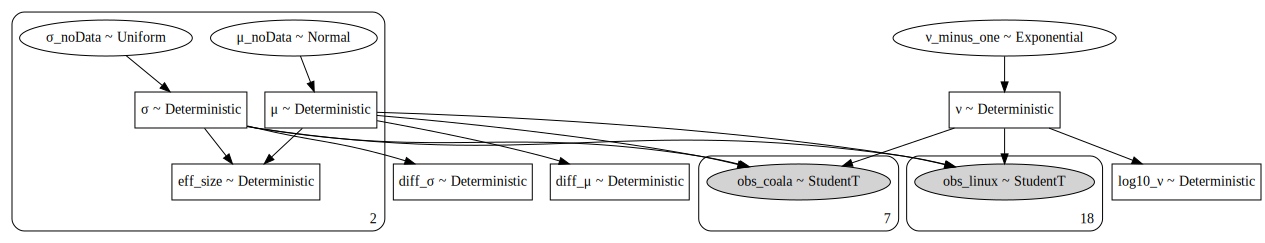

In [10]:
pm.model_to_graphviz(model_h1_pure)

In [11]:
resample=True
def getTrace(folderName, model_h1):
    with model_h1:
        if (resample):
            trace_h1=pm.sample(10000, chains=4, cores=1, step=pm.NUTS())
            pm.save_trace(trace_h1, folderName, overwrite=True)
            
        trace_h1  = pm.load_trace(folderName)
        trace_h1_inferencedata = az.from_pymc3(trace_h1, model = model_h1)
    return (trace_h1, trace_h1_inferencedata)

(trace_h1_pure, trace_h1_inferencedata_pure) = getTrace("h1_pure.trace", model_h1_pure)

# The sampler is still giving the error - SamplingError: Bad initial energy
# (trace_h1_positive, trace_h1_inferencedata_positive) = getTrace("h1_positive.trace", model_h1_positive)

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]
Sampling chain 3, 0 divergences: 100%|█████████████████████████████████████████| 10500/10500 [00:09<00:00, 1162.79it/s]


In [12]:
az.summary(trace_h1_pure)

C:\Users\Stha\miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.011,0.149,0.735,1.295,0.001,0.001,21536.0,21536.0,24846.0,20237.0,1.0
μ_noData[1],1.003,0.080,0.851,1.154,0.000,0.000,34100.0,34100.0,34605.0,27542.0,1.0
μ[0],1.733,0.256,1.259,2.220,0.002,0.001,21536.0,21536.0,24846.0,20237.0,1.0
μ[1],2.898,0.232,2.458,3.334,0.001,0.001,34100.0,34100.0,34605.0,27542.0,1.0
σ_noData[0],1.350,0.571,0.565,2.374,0.004,0.003,19551.0,18303.0,22739.0,21283.0,1.0
σ_noData[1],1.079,0.214,0.719,1.492,0.001,0.001,29951.0,28177.0,31797.0,25058.0,1.0
σ[0],0.610,0.258,0.255,1.073,0.002,0.001,19551.0,18303.0,22739.0,21283.0,1.0
σ[1],0.944,0.188,0.629,1.305,0.001,0.001,29951.0,28177.0,31797.0,25058.0,1.0
ν_minus_one,35.214,30.098,0.396,89.862,0.160,0.116,35417.0,33654.0,26821.0,17369.0,1.0
ν,36.214,30.098,1.396,90.862,0.160,0.116,35417.0,33706.0,26821.0,17369.0,1.0


In [13]:
plt.show()

In [14]:
# az.summary(trace_h1_positive)

In [165]:
var_names_h1=['log10_ν', 'μ', 'σ', 'diff_σ', 'diff_μ']
def plotMethod1(trace_h1_inferencedata, var_names):
    az.plot_posterior(trace_h1_inferencedata, var_names=var_names[:-1], kind='hist', figsize=(8,6)
                      , point_estimate='mean', hdi_prob=0.95);    
    az.plot_posterior(trace_h1_inferencedata, var_names=["diff_μ"], kind='hist', figsize=(8,2.5)
                      , point_estimate='mean', hdi_prob=0.95, ref_val=0, rope=(-h1_diff_rope,+h1_diff_rope));

def plotMethod2(trace_h1, model_h1, var_names):
    az.plot_trace(az.from_pymc3(trace_h1,model=model_h1), var_names=var_names);

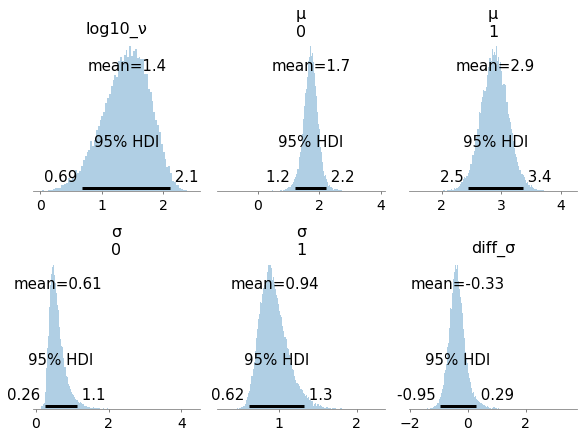

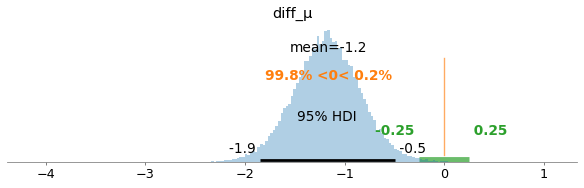

In [16]:
plotMethod1(trace_h1_inferencedata_pure, var_names_h1)

In [17]:
# plotMethod1(trace_h1_inferencedata_positive)

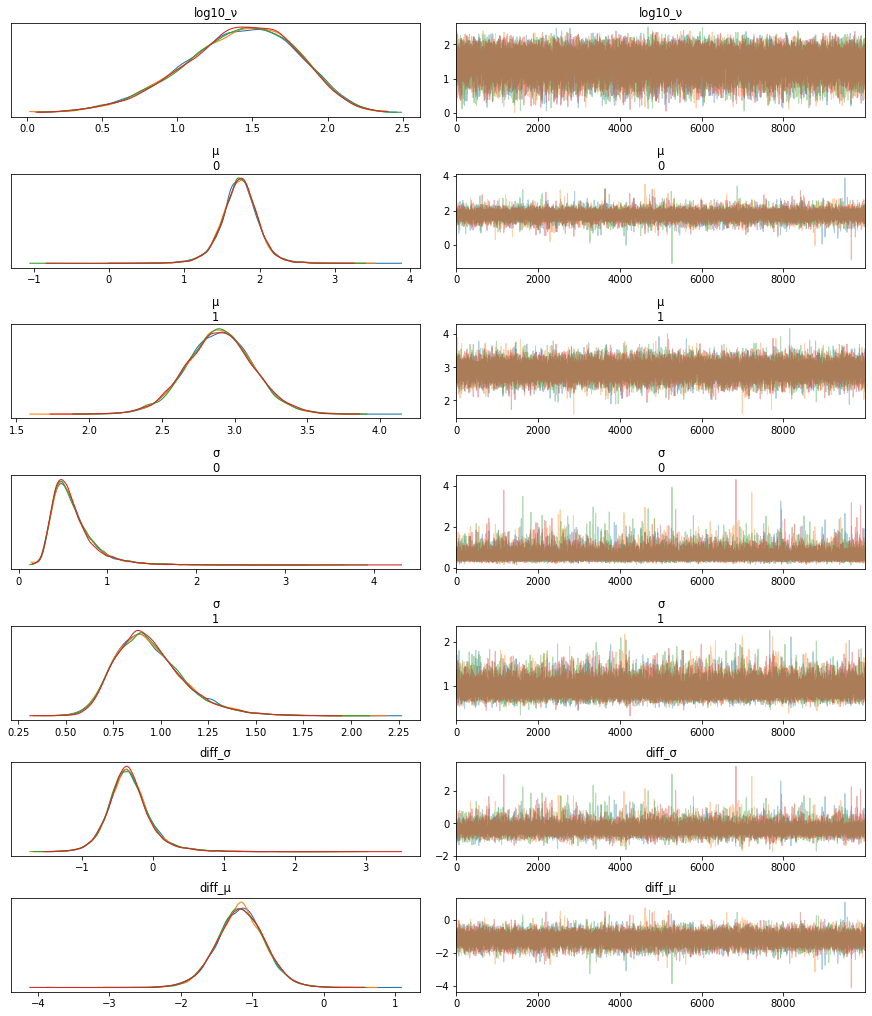

In [18]:
plotMethod2(trace_h1_pure, model_h1_pure, var_names_h1)

In [19]:
# plotMethod2(trace_h1_positive, model_h1_positive)

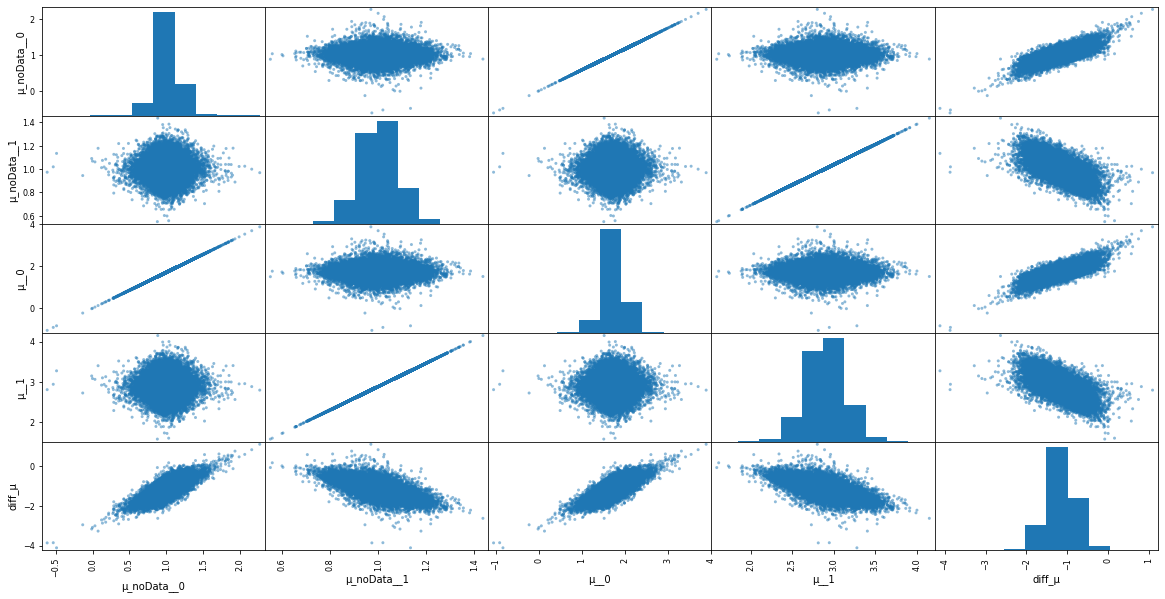

In [20]:
scatter_matrix(pm.trace_to_dataframe(trace_h1_pure, varnames=['μ_noData', 'μ', 'diff_μ']), figsize=(20, 10));
# pm.plot_pair(az.from_pymc3(trace_h1_pure, model=model_h1_pure), var_names=['log10_ν', 'μ', 'diff_μ'])
# plt.show()

## H2

All communities show either a protective or equitable style of governance for pull requests (so for each community answers to V29 and V31 are different)

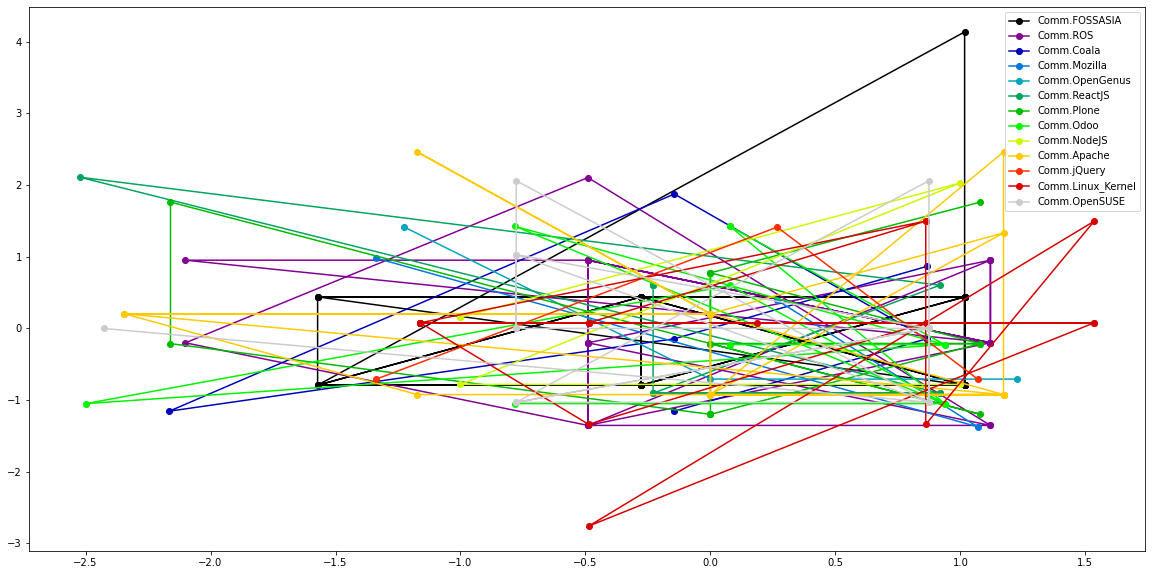

In [116]:
V29_per_com = np.array([df[df.Community == com]["V29"].to_numpy() for com in communities],dtype="object")
V31_per_com = np.array([df[df.Community == com]["V31"].to_numpy() for com in communities],dtype="object")

# Plot data
fig,ax = plt.subplots(figsize=(20,10))

# Define spectrum of colors
number_of_plots=len(communities)
colormap = plt.cm.nipy_spectral
colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
assert(len(colors) == number_of_plots)
ax.set_prop_cycle('color', colors)

# Plot all data together
[ax.plot(getrelevant(com, 2)[3], getrelevant(com, 4)[3], "-", marker='o', label=com) for com in communities]

ax.legend(loc='best')
plt.show()

In [117]:
## Model h2


In [154]:
def flatten(lst):
    res = []
    for inner in lst:
        for v in inner:
            res.append(v)
    return res

V29 = flatten([getrelevant(com, 2)[3] for com in communities])
V31 = flatten([getrelevant(com, 4)[3] for com in communities])
m_29 = [getrelevant(com, 2)[5] for com in communities]
m_31 = [getrelevant(com, 4)[5] for com in communities]
sd_29 = [getrelevant(com, 2)[6] for com in communities]
sd_31 = [getrelevant(com, 4)[6] for com in communities]

In [155]:
print(len(V29), m_x, sd_x)
print(len(V31), m_y, sd_y)

In [156]:
idx = flatten([[i for v in getrelevant(com, 2)[3]] for (i,com) in enumerate(communities)])

In [157]:
print(len(communities), len(idx), len(V29), len(V31))

13 165 165 165


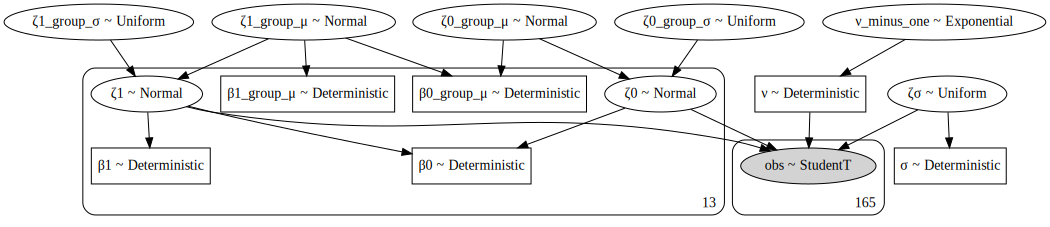

In [158]:
with pm.Model() as model_h2_linear:
    # Prior
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    
    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)
    
    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    
    
    pm.StudentT('obs',
            nu=ν,
            mu=ζ0[idx]+ζ1[idx]*V29,
            sigma=ζσ,
            observed=V31)
    
    #transforming data back
    β0 = pm.Deterministic('β0', (ζ0*sd_31) + m_31 - (ζ1*m_29*sd_31/sd_29))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29)
    
    
    β0_group_μ = pm.Deterministic('β0_group_μ', (ζ0_group_μ*sd_31) + m_31 - (ζ1_group_μ*m_29*sd_31/sd_29))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29)

    σ = pm.Deterministic('σ', ζσ)
    
    
    
pm.model_to_graphviz(model_h2_linear)

In [159]:
resample_h2=True
def getTrace(folderName, model_h2):
    with model_h2:
        if (resample_h2):
            trace_h2=pm.sample(10000, chains=4, cores=1, step=pm.NUTS())
            pm.save_trace(trace_h2, folderName, overwrite=True)
            
        trace_h2  = pm.load_trace(folderName)
        trace_h2_inferencedata = az.from_pymc3(trace_h2, model = model_h2)
    return (trace_h2, trace_h2_inferencedata)

(trace_h2_pure, trace_h2_inferencedata_pure) = getTrace("h2_linear.trace", model_h2_linear)

Sequential sampling (4 chains in 1 job)
NUTS: [ζ1, ζ0, ν_minus_one, ζσ, ζ1_group_σ, ζ0_group_σ, ζ1_group_μ, ζ0_group_μ]
Sampling chain 3, 1,231 divergences: 100%|██████████████████████████████████████| 10500/10500 [00:44<00:00, 236.89it/s]
There were 708 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7042048113775728, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2211 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6409290198352142, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4269 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5977944319803529, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5500 divergences after tuning. Incre

In [161]:
az.summary(trace_h2_pure)

C:\Users\Stha\miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,-0.029,0.084,-0.188,0.126,0.002,0.002,1476.0,1391.0,1472.0,2013.0,1.01
ζ1_group_μ,-0.099,0.108,-0.290,0.101,0.005,0.004,447.0,447.0,459.0,4253.0,1.01
ζ0[0],-0.036,0.103,-0.239,0.153,0.002,0.002,2692.0,2330.0,2461.0,9229.0,1.01
ζ0[1],-0.024,0.106,-0.223,0.178,0.002,0.002,2402.0,1758.0,2168.0,3303.0,1.01
ζ0[2],-0.029,0.123,-0.263,0.207,0.003,0.002,2278.0,1644.0,2048.0,2273.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
β1_group_μ[9],-0.103,0.113,-0.301,0.105,0.005,0.004,447.0,447.0,459.0,4253.0,1.01
β1_group_μ[10],-0.037,0.041,-0.110,0.038,0.002,0.001,447.0,447.0,459.0,4253.0,1.01
β1_group_μ[11],-0.047,0.052,-0.138,0.048,0.002,0.002,447.0,447.0,459.0,4253.0,1.01
β1_group_μ[12],-0.158,0.174,-0.465,0.162,0.008,0.006,447.0,447.0,459.0,4253.0,1.01


In [163]:
var_names_h2=['β0_group_μ','β1_group_μ','ν']

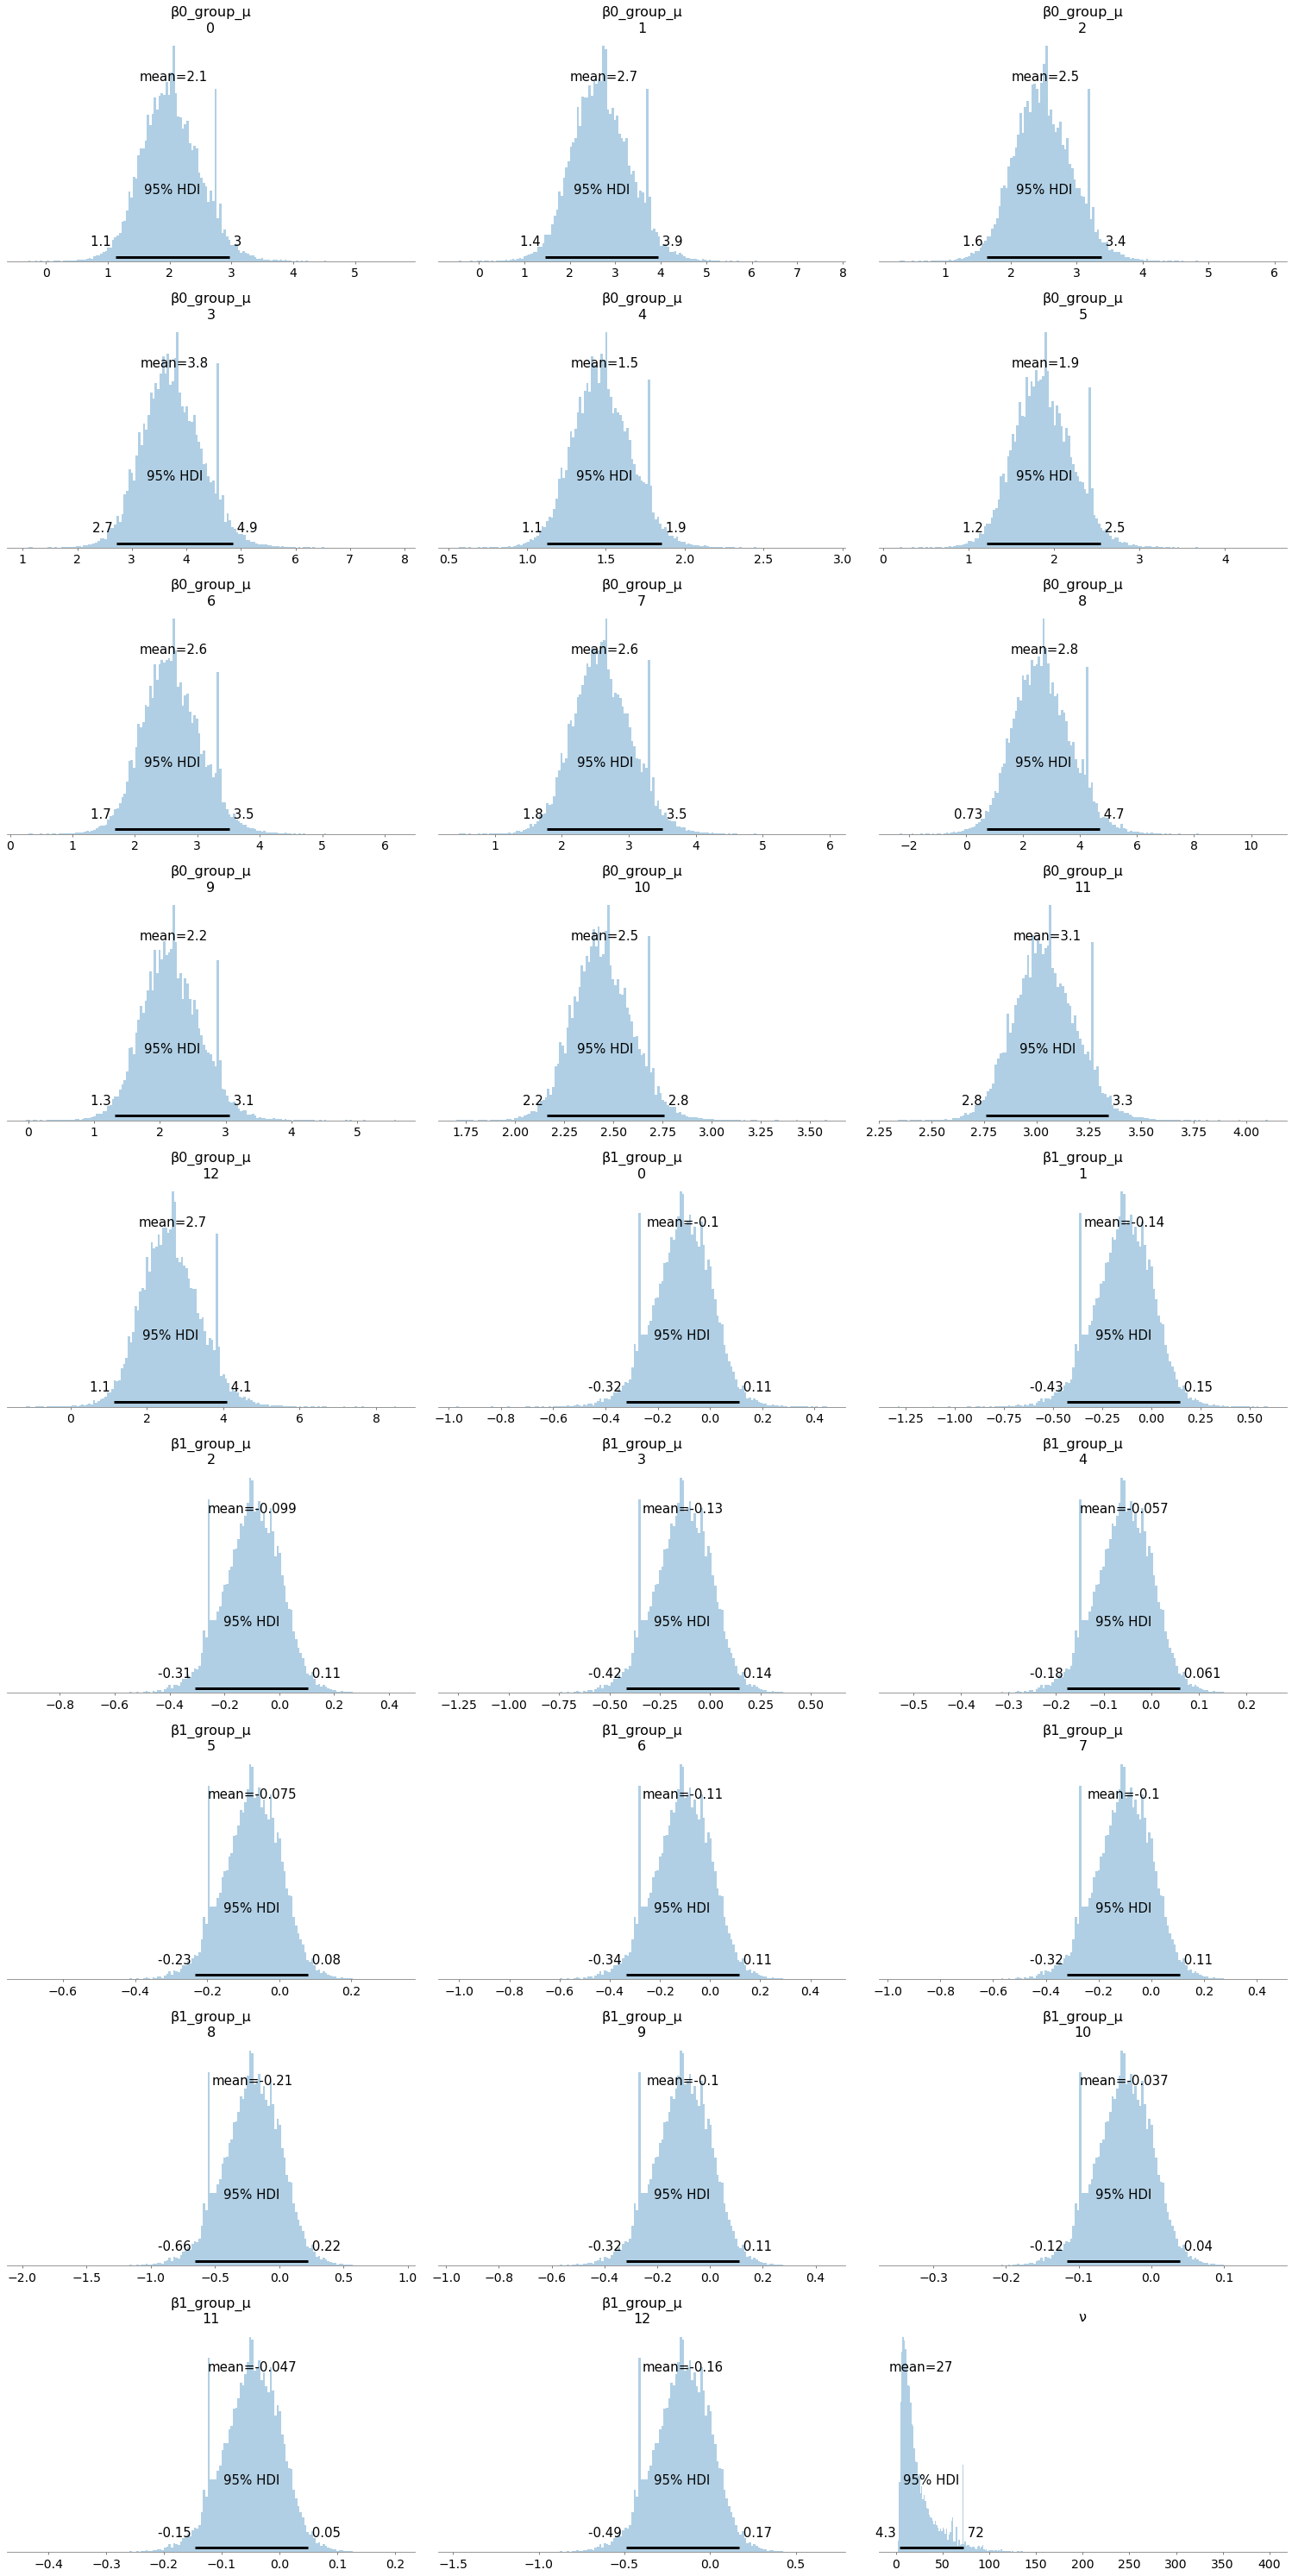

In [171]:
def plotMethod1_h2(trace_h1_inferencedata, var_names):
    az.plot_posterior(trace_h1_inferencedata, var_names=var_names, kind='hist', 
#                       figsize=(8,6),
                      point_estimate='mean', hdi_prob=0.95);
    
plotMethod1_h2(trace_h2_inferencedata_pure, var_names_h2)

C:\Users\Stha\miniconda3\lib\site-packages\arviz\plots\traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


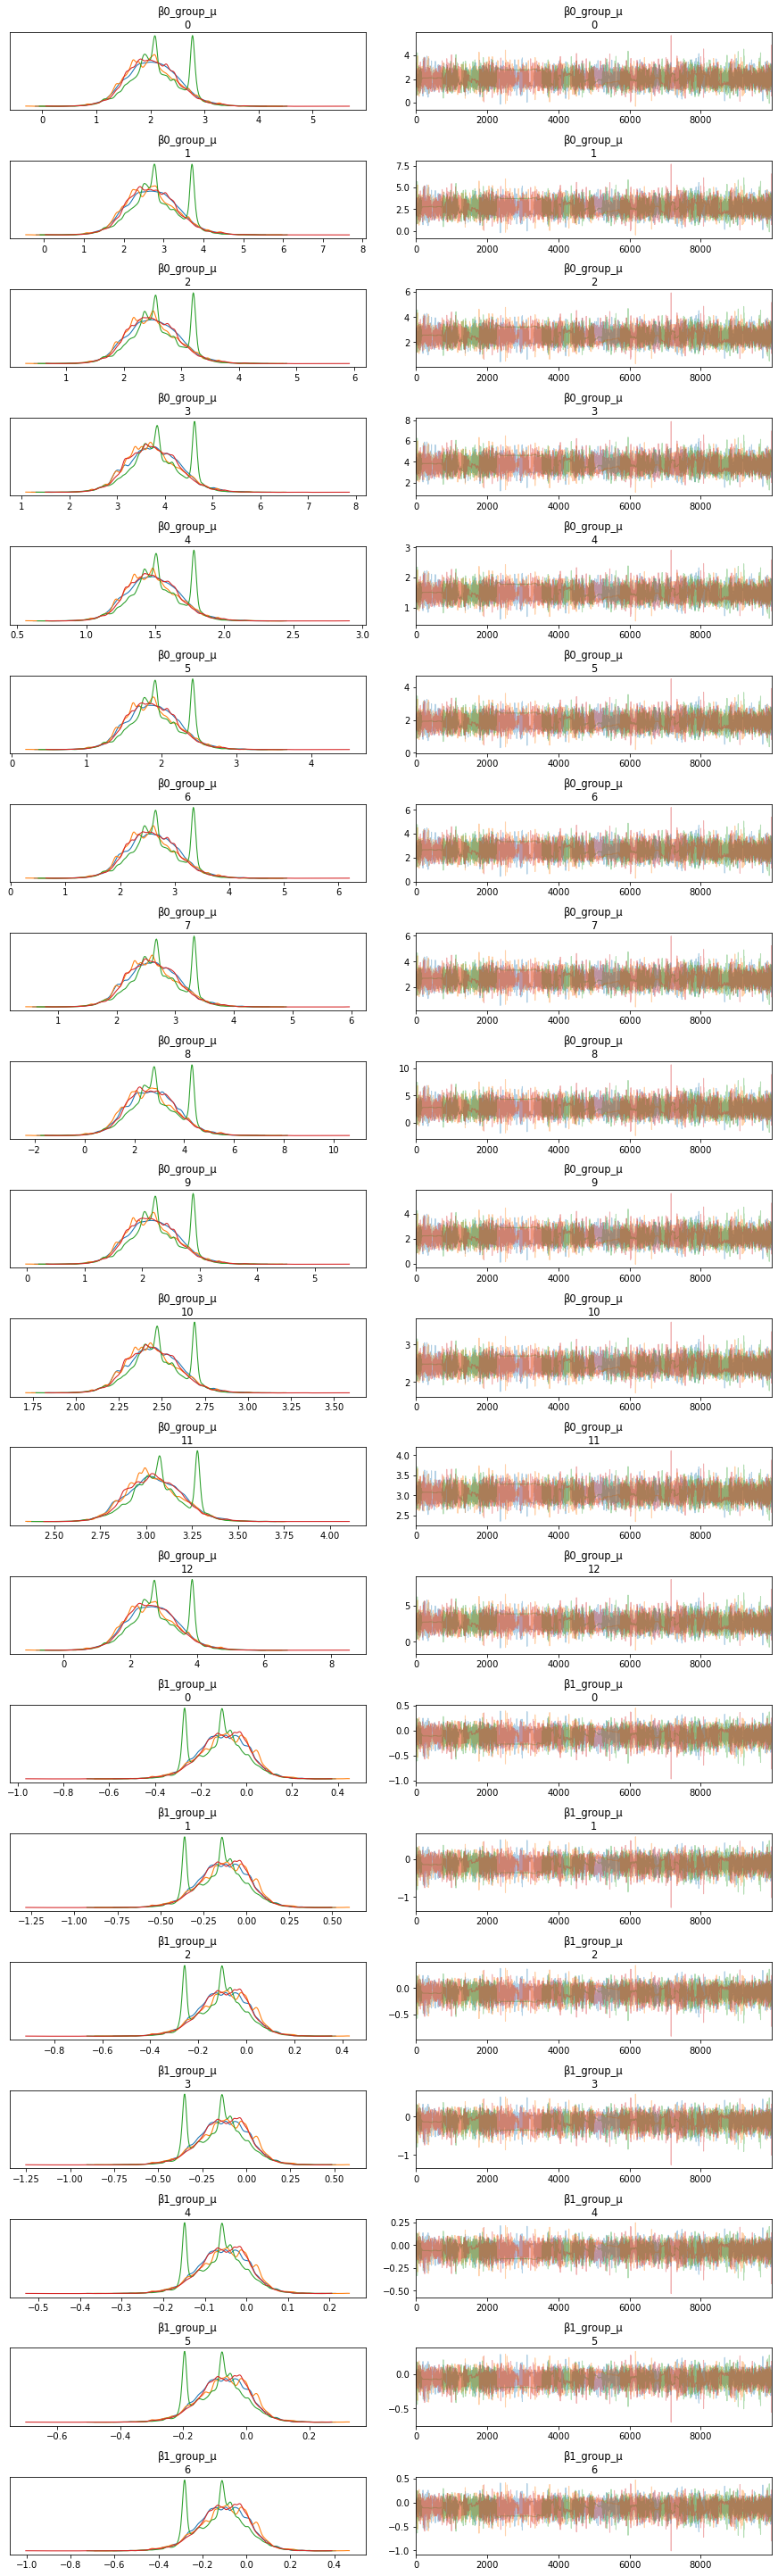

In [172]:
plotMethod2(trace_h2_pure, model_h2_linear, var_names_h2)

[1.         1.05063291 1.10126582 1.15189873 1.20253165 1.25316456
 1.30379747 1.35443038 1.40506329 1.4556962  1.50632911 1.55696203
 1.60759494 1.65822785 1.70886076 1.75949367 1.81012658 1.86075949
 1.91139241 1.96202532 2.01265823 2.06329114 2.11392405 2.16455696
 2.21518987 2.26582278 2.3164557  2.36708861 2.41772152 2.46835443
 2.51898734 2.56962025 2.62025316 2.67088608 2.72151899 2.7721519
 2.82278481 2.87341772 2.92405063 2.97468354 3.02531646 3.07594937
 3.12658228 3.17721519 3.2278481  3.27848101 3.32911392 3.37974684
 3.43037975 3.48101266 3.53164557 3.58227848 3.63291139 3.6835443
 3.73417722 3.78481013 3.83544304 3.88607595 3.93670886 3.98734177
 4.03797468 4.08860759 4.13924051 4.18987342 4.24050633 4.29113924
 4.34177215 4.39240506 4.44303797 4.49367089 4.5443038  4.59493671
 4.64556962 4.69620253 4.74683544 4.79746835 4.84810127 4.89873418
 4.94936709 5.        ]


ValueError: operands could not be broadcast together with shapes (13,) (80,) 

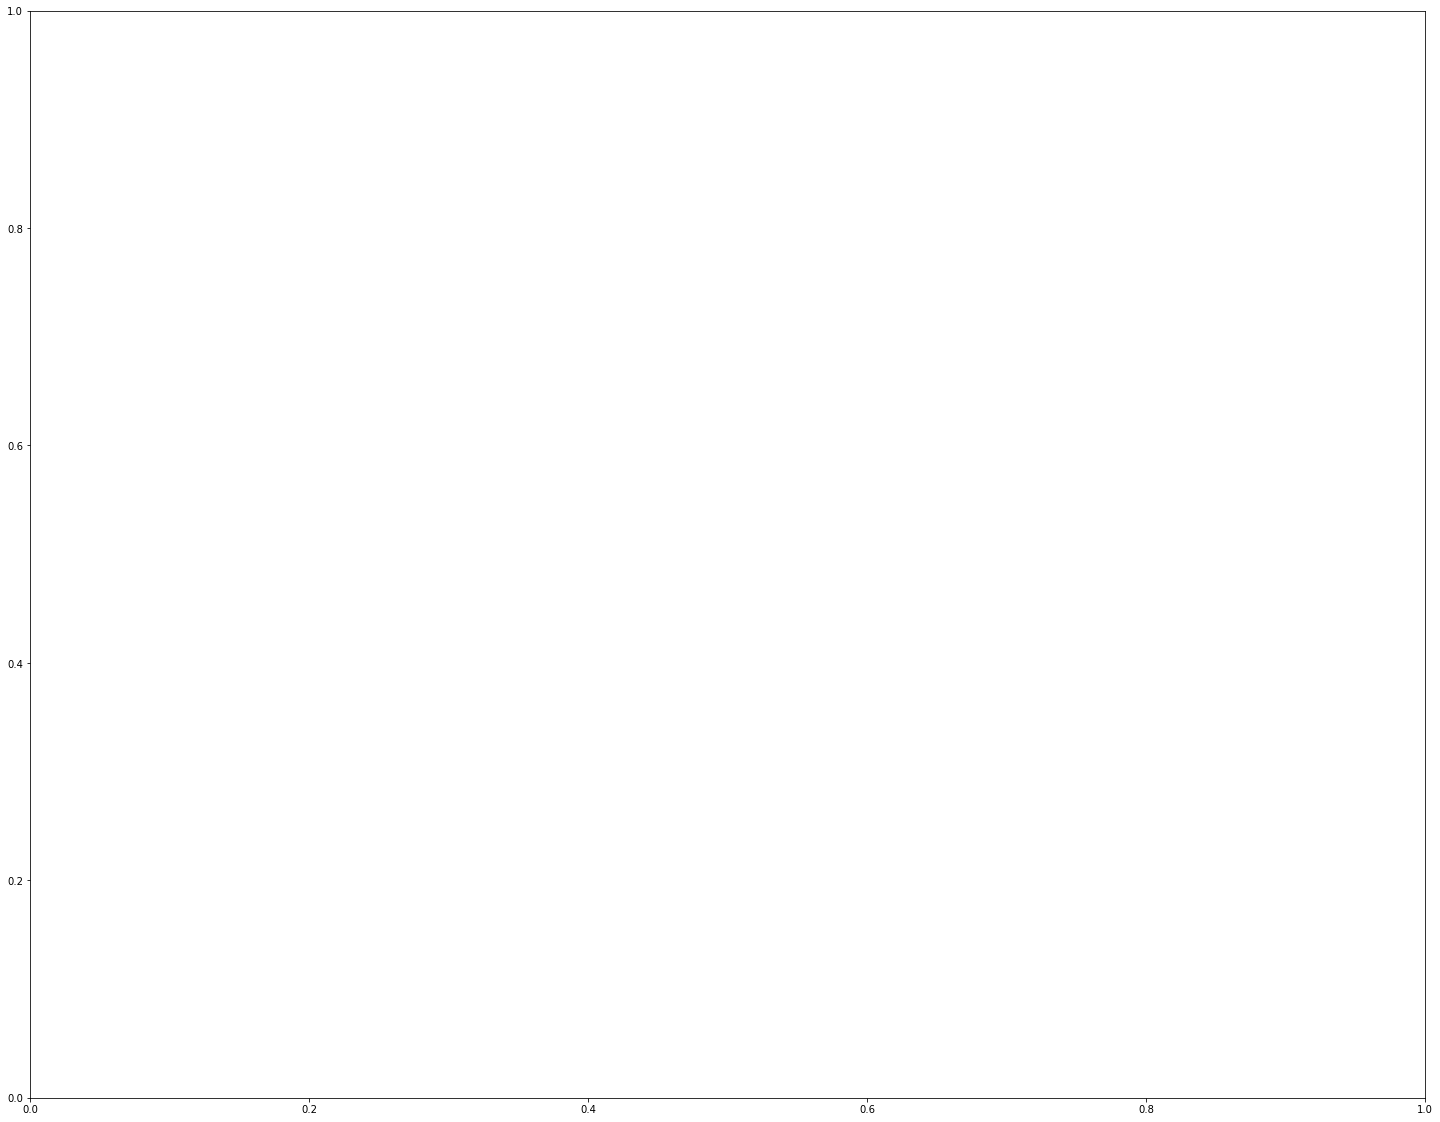

In [180]:
# plotting code
fig,ax = plt.subplots(figsize=(25,20))

xprime = np.linspace(1,5,80)
print(xprime)
[
    ax.plot(xprime,
         trace_h2_pure[i]['β0_group_μ']+trace_h2_pure[i]['β1_group_μ']*xprime,
         color='lightsteelblue')
 for i in np.random.randint(0,len(trace_h2_pure),100)]

# Define spectrum of colors
number_of_plots=len(communities)
colormap = plt.cm.nipy_spectral
colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
ax.set_prop_cycle('color', colors)


# [ax.plot(df[df.State==idx].FamilySize, df[df.State==idx].MedianIncome,
#          marker='o',linestyle='-',
#          label=idx_to_state(idx)) for idx in idxs]
[ax.plot(getrelevant(com, 2)[1], getrelevant(com, 4)[1], "-", marker='o', label=com) for com in communities]

# ax.set_xlim(1,8)
# ax.set_ylim(0,150000)

plt.legend(loc='best')
plt.show()